## https://courseworks2.columbia.edu/courses/190553/files/19587975?wrap=1
## Trading strategy of a stock index based on the frequency of news releases for listed companies

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
from datetime import datetime
import matplotlib.pyplot as plt
import random
random.seed(6666)

from tqdm import tqdm
import concurrent.futures

In [2]:
def load_financial_data(ticker:str, start_date, end_date,output_file):
    try:
        df = pd.read_pickle(output_file)
        print(f'File data found...reading {ticker} data')
    except FileNotFoundError:
        print(f'File not found...downloading the {ticker} data')
        df = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)
        df.to_pickle(output_file)
    return df

In [3]:
spy_data=load_financial_data('SPY', start_date=datetime(2000,1,1), end_date = datetime(2024,1,1), output_file='spy_data.pkl')
spy_data.to_csv('spy.csv')
spy_data.head()

File data found...reading SPY data


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,148.25000,148.25000,143.875000,145.4375,93.591133,8164300
2000-01-04,143.53125,144.06250,139.640625,139.7500,89.931145,8089800
2000-01-05,139.93750,141.53125,137.250000,140.0000,90.092049,12177900
2000-01-06,139.62500,141.50000,137.750000,137.7500,88.644104,6227200
2000-01-07,140.31250,145.75000,140.062500,145.7500,93.792259,8066500


## News Data

In [4]:
import feedparser
from urllib.parse import quote

In [5]:
def encode_string_to_url(input_string):
    encoded_string = quote(input_string)
    return encoded_string

def construct_rss_url(after='2020-06-01', before='2020-06-02', search_terms = ['S&P500', 'SPY TICKER', 'S&P']):
    search_term = '%20OR%20'.join([encode_string_to_url(st) for st in search_terms])
    endpoint = f'https://news.google.com/rss/search?q={search_term}+after:{after}+before:{before}&ceid=US:en&hl=en-US&gl=US'
    return endpoint

def parse_rss_feed(url):
    # Parse the RSS feed
    feed = feedparser.parse(url)

    # Check if the feed parsing was successful
    if feed.bozo == 0:
        return len(feed.entries)
    else:
        # print("Error parsing the RSS feed.")
        raise Exception('Failed feed pull')

In [6]:
news_articles_df = pd.DataFrame(index=spy_data.index, columns=['article_count'])

In [7]:
def load_news_data(output_file):
    try:
        df = pd.read_pickle(output_file)
        print(f'File data found...reading news data')
    except FileNotFoundError:
        # Function to process each date
        def process_date(date):
            after = date.strftime('%Y-%m-%d')
            before = (date + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
            return parse_rss_feed(construct_rss_url(after, before))
        
        # Create ThreadPoolExecutor with maximum workers equal to the number of available CPUs
        with concurrent.futures.ThreadPoolExecutor() as executor:
            # Process each date in parallel
            results = list(tqdm(executor.map(process_date, spy_data.index), total=len(spy_data.index)))
        
        # Combine results into a DataFrame
        for i, date in enumerate(spy_data.index):
            news_articles_df.at[date, 'article_count'] = results[i]
        
        # Save the DataFrame to pickle file
        news_articles_df.to_pickle(output_file)
        
        df = news_articles_df  # Assigning df to the DataFrame after loading the news data
        
    return df

# Load news data in parallel
news_articles_df = load_news_data('news_articles.pkl')

# Save the DataFrame to CSV
news_articles_df.to_csv('news_articles.csv')


File data found...reading news data


In [8]:
((news_articles_df['article_count'].shift() - news_articles_df['article_count'] < 0) * 1.0).sum()

1447.0

## Backtest

In [9]:
def backtest(orders, initial_capital = 10000, risk_free_rate = 0.0467):
    portfolio = pd.DataFrame(index=spy_data.index)
    portfolio['orders'] = orders

    portfolio['cash'] = 0
    portfolio['holding'] = 0
    portfolio['total'] = 0
    portfolio['max_drawdown'] = 0  # New column for maximum drawdown
    portfolio['sharpe_ratio'] = 0  # New column for Sharpe Ratio
    portfolio.at[portfolio.index[0], 'cash'] = initial_capital

    max_value = initial_capital
    returns = []

    for i in range(1, len(portfolio)):
        if portfolio.at[portfolio.index[i], 'orders'] == 1:
            portfolio.at[portfolio.index[i], 'holding'] = portfolio.at[portfolio.index[i-1], 'cash'] / spy_data['Close'][i]
            portfolio.at[portfolio.index[i], 'cash'] = 0
        elif portfolio.at[portfolio.index[i], 'orders'] == -1:
            portfolio.at[portfolio.index[i], 'cash'] = portfolio.at[portfolio.index[i-1], 'holding'] * spy_data['Close'][i]
            portfolio.at[portfolio.index[i], 'holding'] = 0
        else:
            portfolio.at[portfolio.index[i], 'cash'] = portfolio.at[portfolio.index[i-1], 'cash']
            portfolio.at[portfolio.index[i], 'holding'] = portfolio.at[portfolio.index[i-1], 'holding']


    # Update total value and calculate drawdown
        portfolio.at[portfolio.index[i], 'total'] = portfolio.at[portfolio.index[i], 'cash'] + portfolio.at[portfolio.index[i], 'holding'] * spy_data['Close'][i]
        
        max_value = max(max_value, portfolio.at[portfolio.index[i], 'total'])
        portfolio.at[portfolio.index[i], 'max_drawdown'] = (max_value - portfolio.at[portfolio.index[i], 'total']) / max_value

    # Calculate daily returns
        if i > 1:
            daily_return = (portfolio.at[portfolio.index[i], 'total'] / portfolio.at[portfolio.index[i-1], 'total']) - 1
            returns.append(daily_return)
            #  Calculate Sharpe Ratio
            if pd.Series(returns).std() != 0:
                excess_returns = pd.Series(returns) - risk_free_rate
                sharpe_ratio = (excess_returns.mean() / excess_returns.std())
            else:
                sharpe_ratio = 0.0
            portfolio.at[portfolio.index[i], 'sharpe_ratio'] = sharpe_ratio


    return portfolio

In [10]:
def portfolio_signals(portfolios):
    num_portfolios = len(portfolios)
    fig, axs = plt.subplots(num_portfolios, 1, figsize=(14, 7*num_portfolios))

    for i, (portfolio, ax) in enumerate(zip(portfolios, axs)):
        ax.plot(spy_data.index, spy_data['Close'], label='SPX Close Price')
        ax.plot(portfolio[portfolio['orders'] == 1].index, spy_data['Close'][portfolio['orders'] == 1], '^', markersize=5, color='g', label='Buy Signal')
        ax.plot(portfolio[portfolio['orders'] == -1].index, spy_data['Close'][portfolio['orders'] == -1], 'v', markersize=5, color='r', label='Sell Signal')
        ax.set_title(f'Portfolio {i} Buy and Sell Signals')
        ax.legend()

    plt.tight_layout()
    plt.show()

In [11]:
def portfolio_val_over_time(portfolios):
    num_portfolios = len(portfolios)
    fig, axs = plt.subplots(num_portfolios, 1, figsize=(14, 7*num_portfolios))

    for i, (portfolio, ax) in enumerate(zip(portfolios, axs)):
        ax.plot(portfolio.index, portfolio['total'], label='Total Value')
        ax.plot(portfolio.index, portfolio['cash'], label='Cash')
        ax.plot(portfolio.index, portfolio['holding'], label='Holding Value')
        ax.set_title(f'Portfolio {i} Value Over Time')
        ax.legend()

    plt.tight_layout()
    plt.show()


In [12]:
def plot_portfolio(portfolios, column='max_drawdown'):
    fig, ax = plt.subplots(figsize=(14, 7))

    for i, portfolio in enumerate(portfolios):
        ax.plot(portfolio.index, portfolio[column], label=f'Portfolio {i} - {column}')

    ax.set_title('Portfolios')
    ax.legend()
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.show()


In [13]:
signals = pd.DataFrame(index=spy_data.index)

signals['signal'] = 1
signals.at[signals.index[0], 'signal'] = 0
signals['orders'] = signals['signal'].diff()
portfolio_0 = backtest(signals['orders'])
print(portfolio_0.at[portfolio_0.index[-1], 'total'])


signals['signal'] = [random.randint(0, 1) for _ in range(len(signals))]
signals['orders'] = signals['signal'].diff()
portfolio_1 = backtest(signals['orders'])
print(portfolio_1.at[portfolio_1.index[-1], 'total'])


signals['signal'] = (news_articles_df['article_count'].shift() - news_articles_df['article_count'] < 0) * 1.0
signals['orders'] = signals['signal'].diff()
portfolio_2 = backtest(signals['orders'])
print(portfolio_2.at[portfolio_2.index[-1], 'total'])


# Calculate the sum of articles for each week
news_articles_df['article_count_weekly'] = news_articles_df['article_count'].rolling(window=7).sum()

# Shift the weekly sum to represent the previous week
news_articles_df['article_count_weekly_shifted'] = news_articles_df['article_count_weekly'].shift()

# Set the signal to 1 when the sum of articles from the previous week is less than the sum of this week
signals['signal'] = (news_articles_df['article_count_weekly_shifted'] < news_articles_df['article_count_weekly']).astype(float)
signals['orders'] = signals['signal'].diff()
portfolio_3 = backtest(signals['orders'])
print(portfolio_3.at[portfolio_3.index[-1], 'total'])

# Calculate the 5-day and 20-day moving averages
spy_data['MA5'] = spy_data['Close'].rolling(window=5).mean()
spy_data['MA20'] = spy_data['Close'].rolling(window=20).mean()

# Create a new signal based on the moving averages
signals['signal'] = 0
signals['signal'][5:] = np.where(spy_data['MA5'][5:] > spy_data['MA20'][5:], 1, 0)
signals['orders'] = signals['signal'].diff()

# Perform backtesting with the new signal
portfolio_4 = backtest(signals['orders'])
print(portfolio_4.at[portfolio_4.index[-1], 'total'])


34011.44884140206
22875.29720445749
23383.504180974203
14734.941366369925


C:\Users\chaud\AppData\Local\Temp\ipykernel_38860\696592052.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals['signal'][5:] = np.where(spy_data['MA5'][5:] > spy_data['MA20'][5:], 1, 0)


18138.422417967322


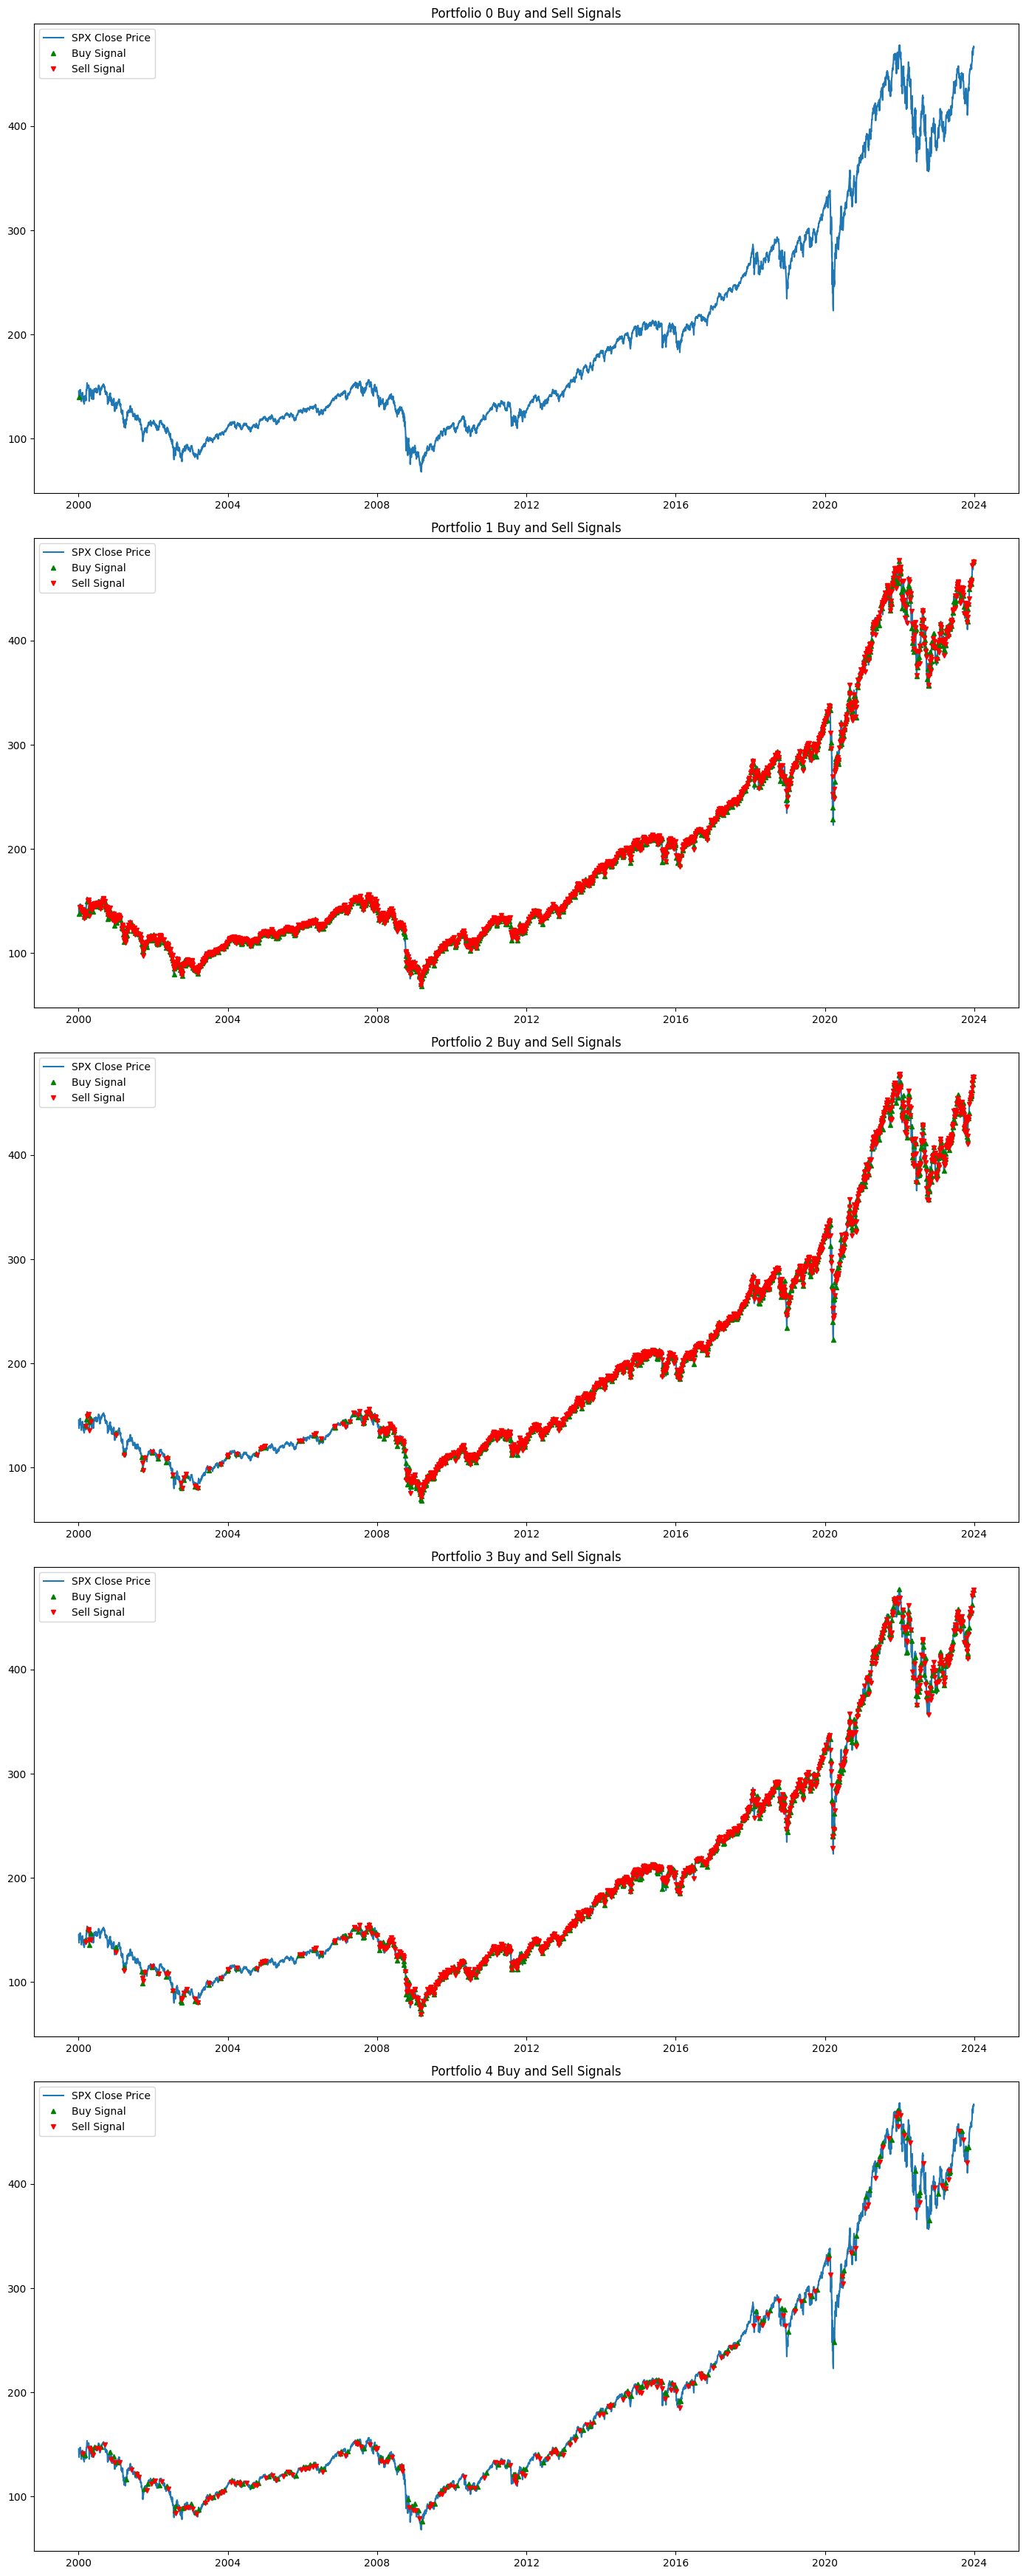

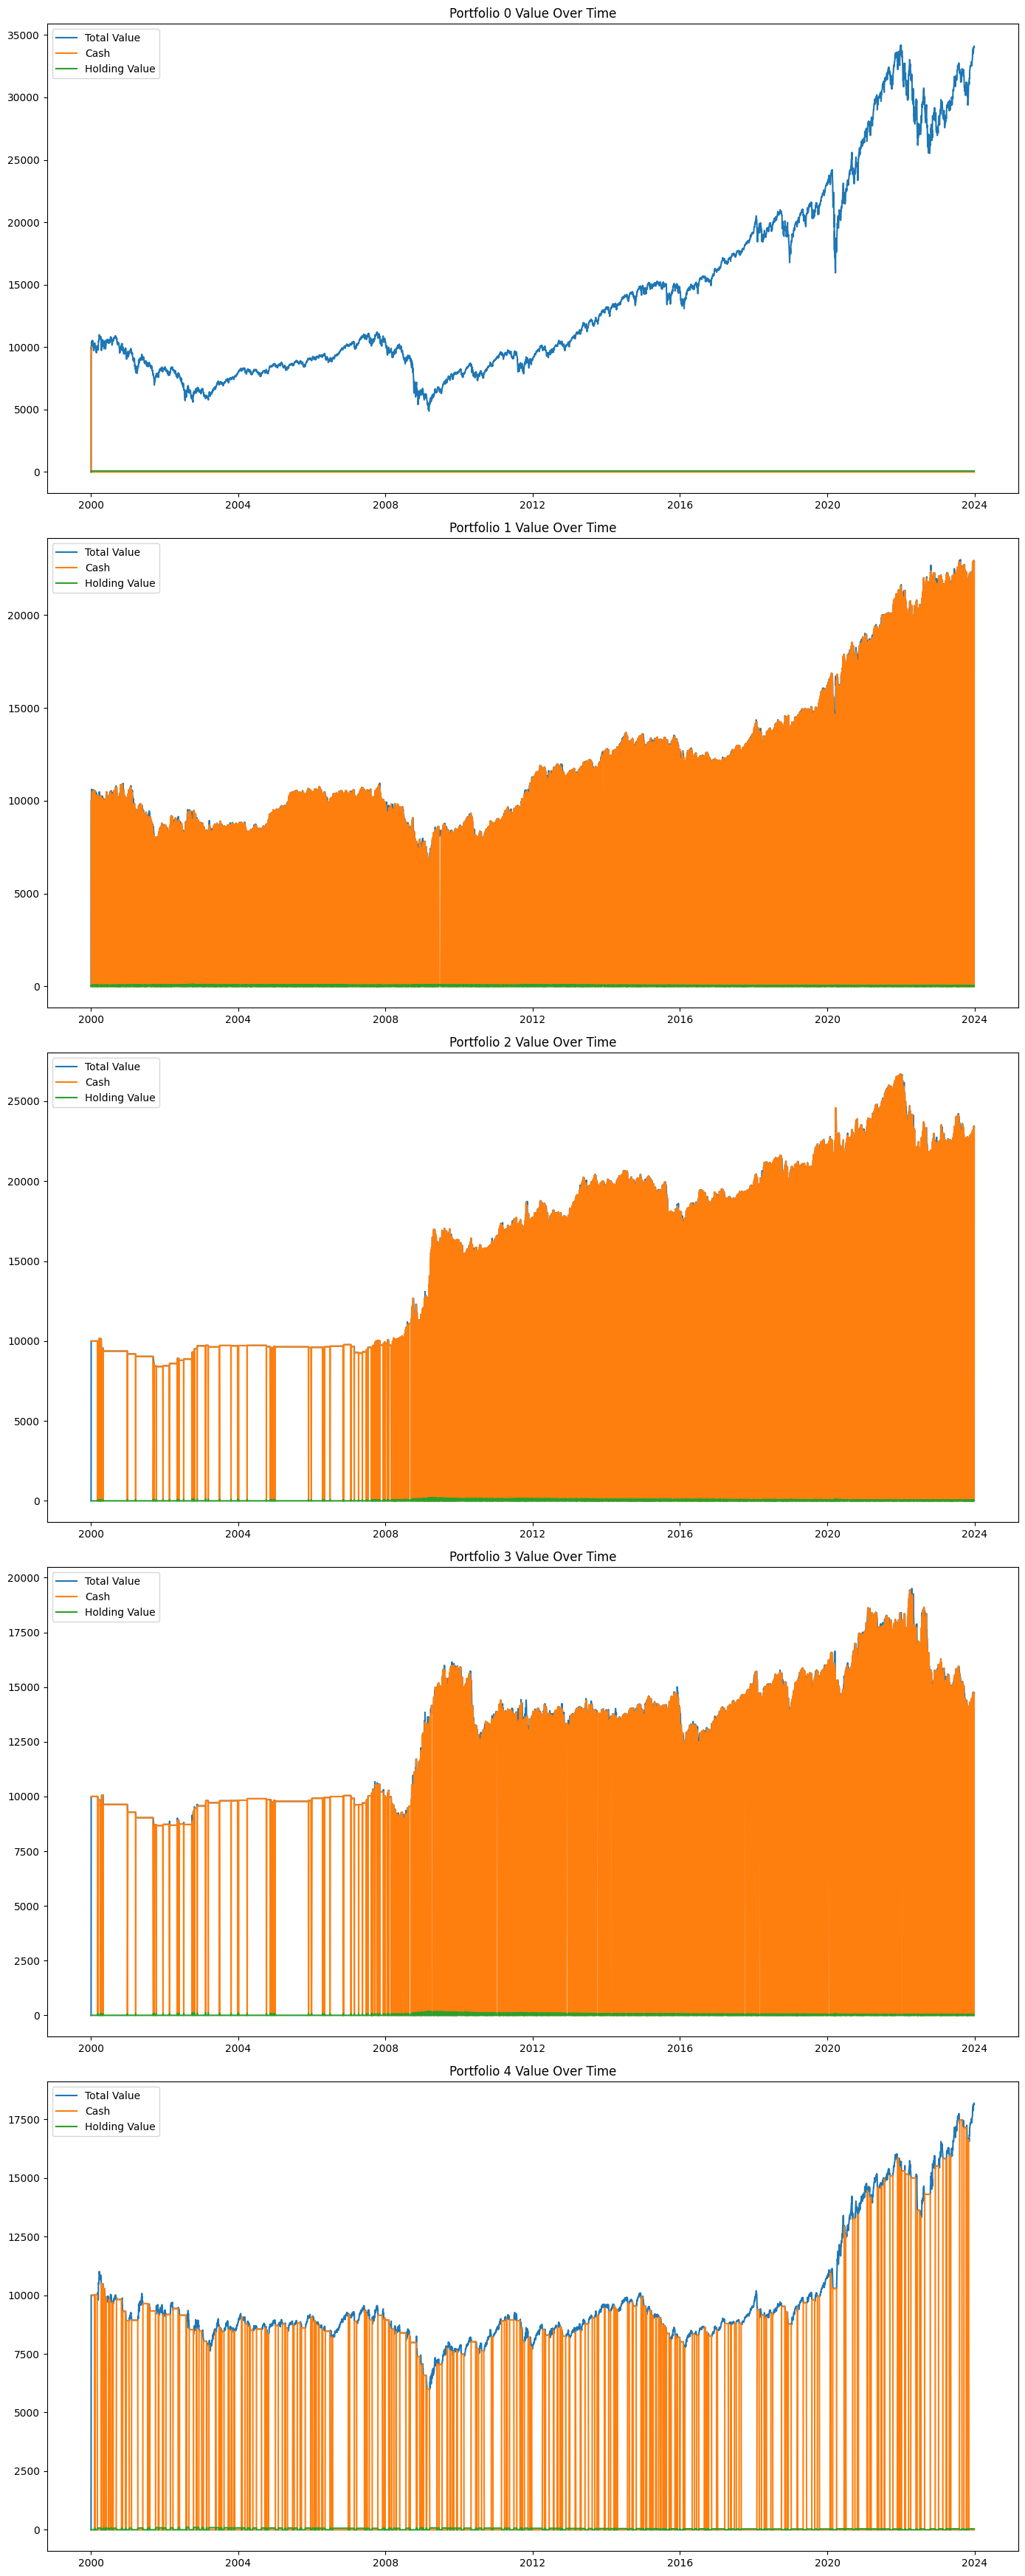

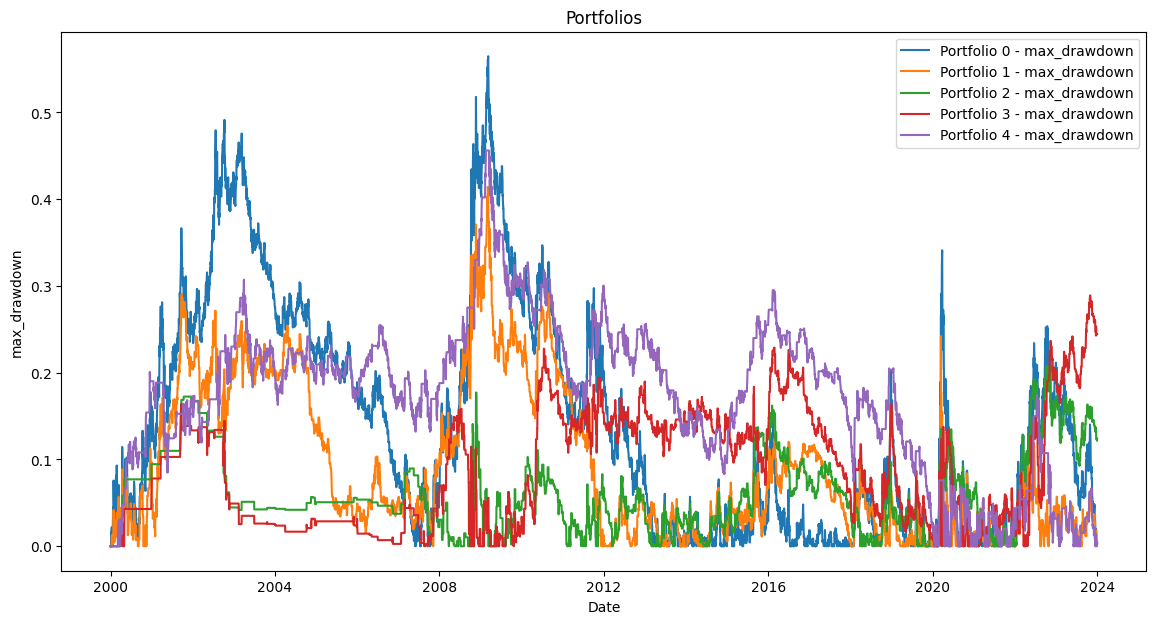

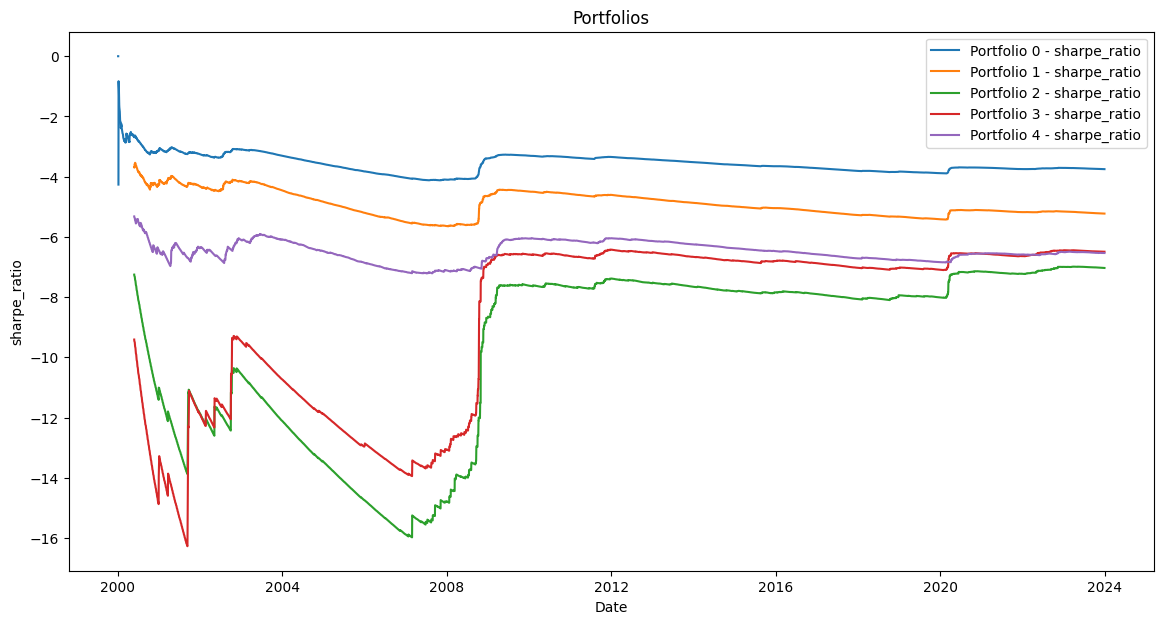

In [14]:
portfolio_signals([portfolio_0, portfolio_1, portfolio_2, portfolio_3, portfolio_4])
portfolio_val_over_time([portfolio_0, portfolio_1, portfolio_2, portfolio_3, portfolio_4])
plot_portfolio([portfolio_0, portfolio_1, portfolio_2, portfolio_3, portfolio_4], 'max_drawdown')
plot_portfolio([portfolio_0, portfolio_1.iloc[100:], portfolio_2.iloc[100:], portfolio_3.iloc[100:], portfolio_4.iloc[100:]], 'sharpe_ratio')